### analisis exploratorio de datos para el caso de la gran encuesta unificada de los hogares colombianos 


Los archivos que se van a cruzar para este analisis son:

1. demograficos.
2. ocupados.
3. ingresos.
4. seguridad social
5. Vivienda y hogar

In [1]:
#Librerias requeridas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
# Bases necesarias para el analisis


path = r"C:/Users/User/OneDrive/Documentos/UNAD/Proyecto de grado/datos"

def normalize_cols(df):
    df.columns = (
        df.columns.str.strip()
                  .str.upper()
                  .str.replace(' ', '_')
                  .str.replace('.', '_')
                  .str.replace('Á','A')
                  .str.replace('É','E')
                  .str.replace('Í','I')
                  .str.replace('Ó','O')
                  .str.replace('Ú','U')
    )
    return df

def cargar_mes_trimestre(nombre_carpeta):
    ruta_carpeta = os.path.join(path, nombre_carpeta)

    archivos = {
        "CARAC": "Características generales, seguridad social en salud y educación.CSV",
        "OCUP": "Ocupados.CSV",
        "FT":   "Fuerza de trabajo.CSV",
        "OTROS": "Otros ingresos e impuestos.CSV"
    }

    dfs = {}
    for clave, archivo in archivos.items():
        ruta = os.path.join(ruta_carpeta, archivo)
        # casi todo viene con ; pero dejamos try por si acaso
        try:
            df = pd.read_csv(ruta, encoding="latin-1", delimiter=";")
        except:
            df = pd.read_csv(ruta, encoding="latin-1", delimiter=",")
        dfs[clave] = normalize_cols(df)

    llaves = ['DIRECTORIO', 'SECUENCIA_P', 'ORDEN']

    carac = dfs["CARAC"]

    # quitar columnas duplicadas en las otras bases
    def only_new_cols(df):
        cols = []
        for c in df.columns:
            if c in llaves:
                cols.append(c)                # siempre conservar llave
            elif c not in carac.columns:
                cols.append(c)                # solo columnas que no estén ya en CARAC
        return df[cols]

    ocup  = only_new_cols(dfs["OCUP"])
    ft    = only_new_cols(dfs["FT"])
    otros = only_new_cols(dfs["OTROS"])

    base = carac.merge(ocup,  on=llaves, how='left') \
                .merge(ft,    on=llaves, how='left') \
                .merge(otros, on=llaves, how='left')

    # marcar el mes
    base['MES_ORIGEN'] = nombre_carpeta

    return base


In [3]:
julio_2025      = cargar_mes_trimestre("Julio 2025")
agosto_2025     = cargar_mes_trimestre("Agosto 2025")
septiembre_2025 = cargar_mes_trimestre("Septiembre 2025")

master_trim_2025 = pd.concat(
    [julio_2025, agosto_2025, septiembre_2025],
    ignore_index=True
)

master_trim_2025.shape


C:\Users\User\AppData\Local\Temp\ipykernel_23904\1597574858.py:35: DtypeWarning: Columns (28,89,147,158) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(ruta, encoding="latin-1", delimiter=";")
C:\Users\User\AppData\Local\Temp\ipykernel_23904\1597574858.py:35: DtypeWarning: Columns (28,89,133,145,147,158) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(ruta, encoding="latin-1", delimiter=";")
C:\Users\User\AppData\Local\Temp\ipykernel_23904\1597574858.py:35: DtypeWarning: Columns (28,89,133,145,147,158) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(ruta, encoding="latin-1", delimiter=";")
C:\Users\User\AppData\Local\Temp\ipykernel_23904\1597574858.py:35: DtypeWarning: Columns (33) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(ruta, encoding="latin-1", delimiter=";")


(205276, 323)

###  Construcción del dataset Maestro

Todo lo anterior que se realizo fue la construcción del dataset Maestro, el cual contiene toda la informacion de los archivos de los meses entre julio y septiembre de 2025 de acuerdo con las bases que se traen al inicio de este notebook.

Para esto se utilizaron las bases:
1. Características generales, seguridad social en salud y educación.
2. Ocupados.
3. Otros ingresos e impuestos.
4. Fuerza de trabajo.

Estas bases se utlizaron debido a que:
1. Características generales, seguridad social en salud y educación: Contiene la informacion de la poblacion, tal como su edad, genero, nivel educativo, entre otros, el cual actua como el dataset maestro.
2. Ocupados: Contiene la informacion de los ocupados, la categoria ocupacional, el tamaño de la empresa, la actividad económica de acuerdo con el codigo CIIU, el tipo de contratación los ingresos y las horas trabajadas. Es importante tener esta base porque nos brinda información de clasificar a la poblacion en ocupados
3. Otros ingresos e impuestos: Contiene la informacion de los ingresos e impuestos, tal como su ingreso, impuesto, entre otros, determina los ingresos no laborales y otras fuentes de ingresos, funicona porque me ayuda a caracterizar brechas y desigualdad.
4. Fuerza de trabajo., contiene si la personas esta ocupada, desocupada, inactiva, asi como la disposición para trabajar, con lo cual se puede asegurar que solo se esta analizando ocupados, que es el especto donde se define la informalidad. 

Se podrían agregar mas variables, como los datos del hogar, varaible categoricas como el estrato, caracteristicas de la vivienda. De igual manera se podria analizar a partir de otras formas de trabajo, para analizar el trabajo no remunerado , trabajo domestico.

La integración de estas bases las hice de la siguiente manera: 

1. se definieron las llaves que son los identificadores que se encuntran en la bases, para esta caso es Directorio, Secuencia_p  y Orden, nos obstante se tuvieron que excluir algunas columnas las cuales se encontraban repetidas en otras bases como podia se la ubicacion del hogar. Esto ultimo etablece a una depuracion y estandarizacion de la base de datos.



#### construcción formal y tecnica de la variable informalidad 

#### Definicion conceptual

El DANE y la OIT definen como ocupado informal a todo trabajador que cumple, al menos, una de las siguientes condiciones:

1. Trabaja en establecimientos o unidades productivas pequeñas, es decir, empresas, negocios o actividades donde participan pocas personas.
2. No está afiliado al sistema de seguridad social en salud.
3. No cotiza al sistema general de pensiones, a pesar de estar ocupado.
4. Debe encontrarse ocupado durante la semana de referencia de la encuesta.

Para este estudio, la variable binaria INFORMAL se construye mediante tres componentes observables en los microdatos de la GEIH 2023.

#### Definición operativa

Para la construcción de la variable informalidad operativa se debe consttuir combinando 3 componentes:

1. Identificación de  ocupado = Variable: P6240 – “La semana pasada, ¿trabajó al menos una hora?”

1 = Sí → ocupado

2 = No → no ocupado

2. Tamaño de la unidad productiva

Variable: P3069 – Número total de personas en el sitio donde trabaja

Las categorías representan:

1 = trabaja solo

2 = 2 a 3 personas

3 = 4 a 5 personas

4 o más = unidades mayores

Se considera unidad productiva pequeña si: menor a 5 personas 

3. Afiliación a seguridad social en salud

Variable: P6090

1 = Sí (está afiliado/cotiza/beneficiario)

2 = No

9 = No sabe

4. Cotización a pensión

Variable correcta: P6920 (módulo Ocupados)

1 = Sí

2 = No

### Reglas Combinadas 
Una persona se clasifica como informal (INFORMAL = 1) si:

Está ocupada (P6240 = 1), y

Cumple al menos una de las siguientes condiciones:

● Trabaja en una unidad productiva pequeña (P3069 ∈ {1, 2, 3})
● No está afiliada al sistema de salud (P6090 ≠ 1)
● No cotiza al sistema general de pensiones (P6920 ≠ 1)

Una persona se clasifica como formal (INFORMAL = 0) si:

Está ocupada, y

Trabaja en una unidad productiva grande (P3069 ≥ 4), y

Está afiliada al sistema de salud (P6090 = 1), y

Cotiza a pensión (P6920 = 1)

In [4]:
# 1. Ocupado
master_trim_2025['ocupado'] = (master_trim_2025['P6240'] == 1).astype(int)

# 2. Unidad productiva pequeña (hasta 5 personas)
master_trim_2025['unidad_pequena'] = master_trim_2025['P3069'].isin([1,2,3]).astype(int)

# 3. No afiliado a salud
master_trim_2025['no_salud'] = (master_trim_2025['P6090'] != 1).astype(int)

# 4. No cotiza a pensión (variable correcta)
master_trim_2025['no_pension'] = (master_trim_2025['P6920'] != 1).astype(int)

# 5. INFORMALIDAD
master_trim_2025['INFORMAL'] = (
    (master_trim_2025['ocupado'] == 1) &
    (
        (master_trim_2025['unidad_pequena'] == 1) |
        (master_trim_2025['no_salud'] == 1) |
        (master_trim_2025['no_pension'] == 1)
    )
).astype(int)


In [5]:
ocupados = master_trim_2025[master_trim_2025['ocupado'] == 1].copy()

In [6]:
tasa_informal = ocupados['INFORMAL'].mean()
print(f"Tasa de informalidad: {tasa_informal*100:.2f}%")


Tasa de informalidad: 59.99%


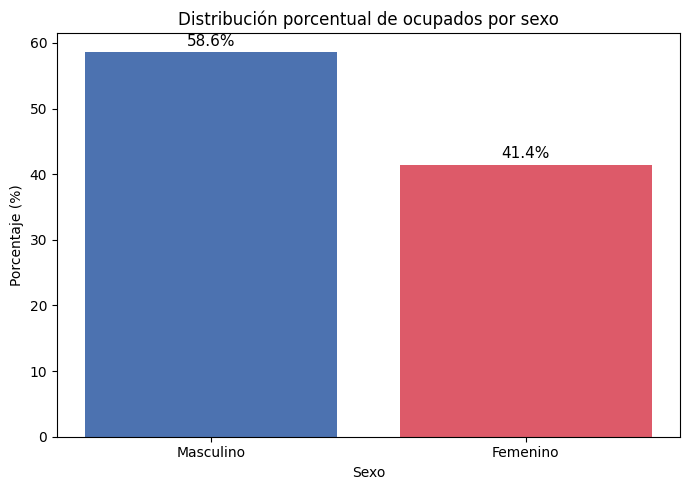

In [7]:
# Distribución de ocupados por sexo (PORCENTAJE)

# 1 = masculino
# 2 = femenino  

dict_genero = {
    1: "Masculino",
    2: "Femenino"
}

# Conteo
conteo = ocupados['P3271'].value_counts().sort_index()

# Convertir a porcentaje
porcentaje = (conteo / conteo.sum()) * 100

# Etiquetas
labels = [dict_genero[i] for i in porcentaje.index]

# Colores en el mismo orden
colores = ["#4C72B0", "#DD5A69"]   # azul hombres, rosa mujeres

plt.figure(figsize=(7,5))

plt.bar(
    range(len(porcentaje)),
    porcentaje.values,
    color=colores
)

plt.xticks(range(len(porcentaje)), labels)
plt.xlabel("Sexo")
plt.ylabel("Porcentaje (%)")
plt.title("Distribución porcentual de ocupados por sexo")

# Mostrar el porcentaje encima de cada barra
for i, v in enumerate(porcentaje.values):
    plt.text(i, v + 1, f"{v:.1f}%", ha='center', fontsize=11)

plt.tight_layout()
plt.show()


La participación laboral en la población ocupada está claramente masculinizada:

6 de cada 10 ocupados son hombres

4 de cada 10 ocupados son mujeres

Esto es consistente con la realidad del mercado laboral colombiano, donde:

La tasa de participación femenina es menor

Existen mayores barreras estructurales para que las mujeres accedan al empleo remunerado

Las mujeres asumen una mayor carga de trabajo doméstico y de cuidado

In [8]:
informalidad_por_sexo = ocupados.groupby('P3271')['INFORMAL'].mean() * 100
informalidad_por_sexo

P3271
1    64.078780
2    54.192021
Name: INFORMAL, dtype: float64

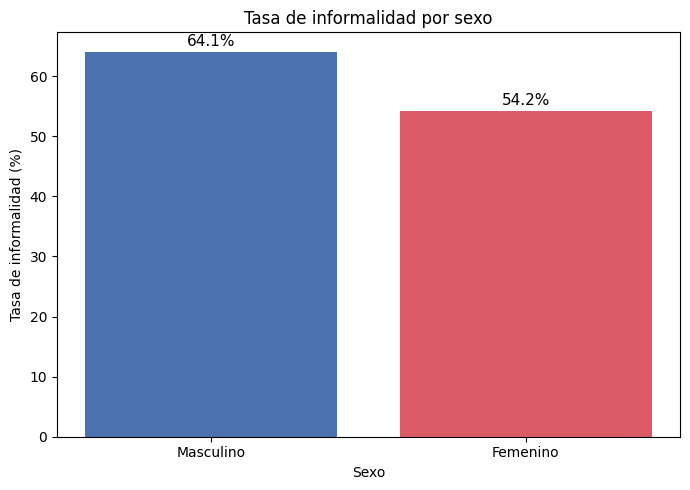

In [9]:
# Calcular informalidad por sexo en %
informalidad_por_sexo = ocupados.groupby('P3271')['INFORMAL'].mean() * 100

# Etiquetas
labels = [dict_genero[i] for i in informalidad_por_sexo.index]

# Colores personalizados
colores = ["#4C72B0", "#DD5A69"]   # azul para hombres, rosa para mujeres

plt.figure(figsize=(7,5))

plt.bar(
    labels,
    informalidad_por_sexo.values,
    color=colores
)

plt.xlabel("Sexo")
plt.ylabel("Tasa de informalidad (%)")
plt.title("Tasa de informalidad por sexo")

# Mostrar porcentaje encima de cada barra
for i, v in enumerate(informalidad_por_sexo.values):
    plt.text(i, v + 1, f"{v:.1f}%", ha='center', fontsize=11)

plt.tight_layout()
plt.show()

Los hombres no solo representan una proporción mayor del empleo total, sino que además presentan niveles más altos de informalidad que las mujeres. Esto evidencia que la informalidad en Colombia está fuertemente asociada a sectores masculinizados como la construcción, el transporte y ciertos segmentos del comercio

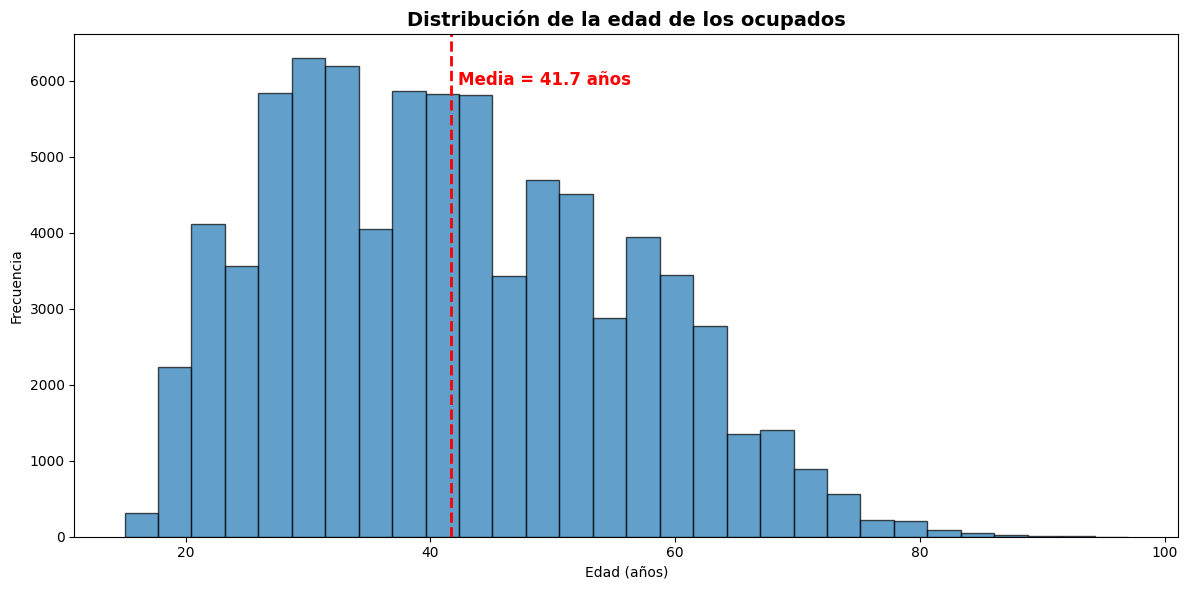

In [10]:
# distribuccion de edad

# Datos
edades = ocupados['P6040']

# Cálculo de la media
media_edad = edades.mean()

plt.figure(figsize=(12,6))

# Histograma más vistoso
plt.hist(
    edades,
    bins=30,
    edgecolor='black',
    alpha=0.7
)

# Línea vertical de la media
plt.axvline(media_edad, color='red', linewidth=2, linestyle='--')

# Texto con el valor de la media
plt.text(
    media_edad + 0.5,   # un poquito a la derecha de la línea
    plt.ylim()[1] * 0.9,  # cerca del borde superior
    f"Media = {media_edad:.1f} años",
    color='red',
    fontsize=12,
    fontweight='bold'
)

# Títulos
plt.title("Distribución de la edad de los ocupados", fontsize=14, fontweight='bold')
plt.xlabel("Edad (años)")
plt.ylabel("Frecuencia")

plt.tight_layout()
plt.show()


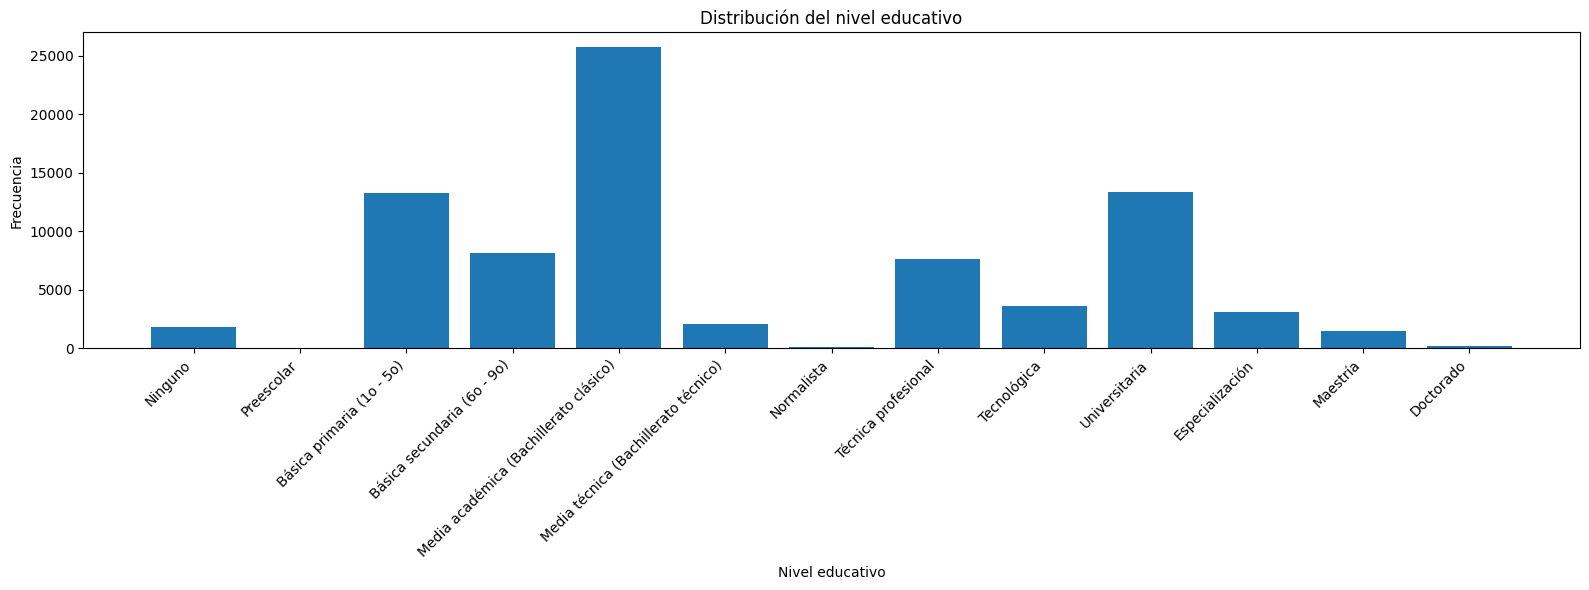

In [11]:

dict_educacion = {
    1: 'Ninguno',
    2: 'Preescolar',
    3: 'Básica primaria (1o - 5o)',
    4: 'Básica secundaria (6o - 9o)',
    5: 'Media académica (Bachillerato clásico)',
    6: 'Media técnica (Bachillerato técnico)',
    7: 'Normalista',
    8: 'Técnica profesional',
    9: 'Tecnológica',
    10: 'Universitaria',
    11: 'Especialización',
    12: 'Maestría',
    13: 'Doctorado'
}

# Conteo usando los códigos numéricos
conteo = ocupados['P3042'].value_counts().sort_index()

# Reemplazar los índices por los nombres del diccionario
labels = [dict_educacion[i] for i in conteo.index]

plt.figure(figsize=(16,6))
plt.bar(range(len(conteo)), conteo.values)

plt.xticks(range(len(conteo)), labels, rotation=45, ha='right')
plt.xlabel("Nivel educativo")
plt.ylabel("Frecuencia")
plt.title("Distribución del nivel educativo")

plt.tight_layout()
plt.show()

In [39]:
diccionario_ramas = {
    1: "Agropecuario",
    2: "Pesca",
    5: "Minería",
    7: "Extracción petróleo y gas",
    8: "Industrias extractivas",
    10: "Alimentos",
    11: "Bebidas",
    12: "Tabaco",
    13: "Textiles",
    14: "Confecciones",
    15: "Cuero y calzado",
    16: "Madera y muebles",
    17: "Papel",
    18: "Impresión",
    19: "Coque y derivados",
    20: "Químicos",
    21: "Farmacéuticos",
    22: "Plástico",
    23: "Minerales no metálicos",
    24: "Metales",
    25: "Metalmecánica",
    26: "Electrónica",
    27: "Eléctricos",
    28: "Maquinaria",
    29: "Vehículos",
    30: "Otros equipos transporte",
    31: "Muebles",
    32: "Otras manufacturas",
    33: "Reparación industrial",
    35: "Electricidad y gas",
    36: "Agua",
    37: "Aguas residuales",
    38: "Desechos",
    39: "Saneamiento",
    41: "Construcción edificios",
    42: "Ingeniería civil",
    43: "Actividades especializadas construcción",
    45: "Comercio vehículos",
    46: "Comercio mayorista",
    47: "Comercio minorista",
    49: "Transporte terrestre",
    50: "Transporte acuático",
    51: "Transporte aéreo",
    52: "Almacenamiento",
    53: "Correo",
    55: "Alojamiento",
    56: "Comidas y restaurantes",
    58: "Editorial",
    59: "Cine y TV",
    60: "Radio",
    61: "Telecomunicaciones",
    62: "Software y TI",
    63: "Procesamiento datos",
    64: "Finanzas",
    65: "Seguros",
    66: "Auxiliares financieros",
    68: "Inmobiliarias",
    69: "Servicios jurídicos/contables",
    70: "Administrativas empresariales",
    71: "Ingeniería y arquitectura",
    72: "Investigación científica",
    73: "Publicidad",
    74: "Profesionales varios",
    75: "Veterinaria",
    77: "Arrendamiento",
    78: "Empleo temporal",
    79: "Agencias de viaje",
    80: "Seguridad privada",
    81: "Servicios generales",
    82: "Administrativos",
    84: "Administración pública",
    85: "Educación",
    86: "Salud",
    87: "Residencias asistidas",
    88: "Asistencia social",
    90: "Arte y entretenimiento",
    91: "Museos",
    92: "Juegos de azar",
    93: "Deportes",
    94: "Asociaciones",
    95: "Reparación equipos",
    96: "Servicios personales",
    97: "Hogares empleadores",
    98: "Hogares no diferenciados",
    99: "Organismos internacionales"
}
informalidad_rama = (
    ocupados.groupby('RAMA2D_R4')['INFORMAL']
            .mean()
            .sort_values(ascending=False)
)
informalidad_rama

informalidad_rama_pct = informalidad_rama * 100
informalidad_rama_pct
informalidad_rama_con_nombres = informalidad_rama_pct.rename(index=diccionario_ramas)
informalidad_rama_con_nombres



RAMA2D_R4
0.0                     100.000000
Hogares empleadores      99.963208
Reparación equipos       95.976331
3.0                      95.600000
Servicios personales     93.854474
                           ...    
Transporte aéreo          1.333333
Eléctricos                1.123596
6.0                       0.000000
Coque y derivados         0.000000
Aguas residuales          0.000000
Name: INFORMAL, Length: 88, dtype: float64

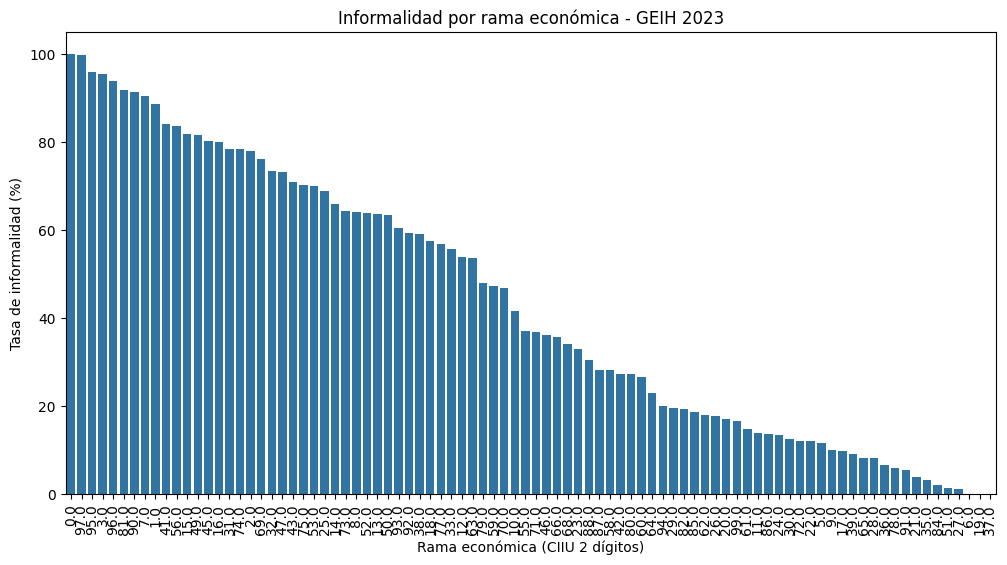

In [13]:
plt.figure(figsize=(12,6))
sns.barplot(
    x=informalidad_rama_pct.index.astype(str),
    y=informalidad_rama_pct.values
)
plt.xticks(rotation=90)
plt.ylabel('Tasa de informalidad (%)')
plt.xlabel('Rama económica (CIIU 2 dígitos)')
plt.title('Informalidad por rama económica - GEIH 2023')
plt.show()

In [14]:
ocupados = master_trim_2025[master_trim_2025['ocupado'] == 1].copy()

informalidad_rama = (
    ocupados.groupby('RAMA2D_R4')['INFORMAL']
            .mean()
            .sort_values(ascending=False)
)

In [15]:
top20 = informalidad_rama.head(20)
top20


RAMA2D_R4
0.0     1.000000
97.0    0.999632
95.0    0.959763
3.0     0.956000
96.0    0.938545
81.0    0.919251
90.0    0.913978
7.0     0.904459
1.0     0.886450
41.0    0.841328
56.0    0.837254
15.0    0.818182
49.0    0.817132
45.0    0.802188
16.0    0.801802
31.0    0.785942
74.0    0.784553
2.0     0.781250
69.0    0.762615
32.0    0.733871
Name: INFORMAL, dtype: float64

In [16]:
diccionario_top20 = {
    rama: diccionario_ramas.get(rama, "Descripción no disponible")
    for rama in top20.index
}

diccionario_top20


{0.0: 'Descripción no disponible',
 97.0: 'Actividades de hogares como empleadores',
 95.0: 'Reparación de computadores y efectos personales',
 3.0: 'Descripción no disponible',
 96.0: 'Otras actividades de servicios',
 81.0: 'Servicios generales',
 90.0: 'Actividades artísticas',
 7.0: 'Extracción de petróleo y gas',
 1.0: 'Agricultura, ganadería, caza y silvicultura',
 41.0: 'Construcción de edificios',
 56.0: 'Servicios de comidas',
 15.0: 'Curtido y fabricación de artículos de cuero',
 49.0: 'Transporte terrestre',
 45.0: 'Comercio de vehículos',
 16.0: 'Transformación de madera y fabricación de muebles',
 31.0: 'Fabricación de muebles y colchones',
 74.0: 'Otras actividades profesionales',
 2.0: 'Pesca y acuicultura',
 69.0: 'Servicios jurídicos y contables',
 32.0: 'Otras industrias manufactureras'}

In [17]:
comparacion =  master_trim_2025.groupby('INFORMAL')['INGLABO'].agg(
    promedio='mean',
    mediana='median',
    desv_std='std',
    minimo='min',
    maximo='max',
    n='count'
)

# Cambiar 0 y 1 por 'Formal' y 'Informal'
comparacion.index = comparacion.index.map({0: 'Formal', 1: 'Informal'})
comparacion


,promedio,mediana,desv_std,minimo,maximo,n
INFORMAL,,,,,,
Formal,2.322279e+06,1623000.0,2.659866e+06,0.0,97000000.0,40760
Informal,1.328590e+06,1100000.0,1.598620e+06,0.0,80000000.0,47754


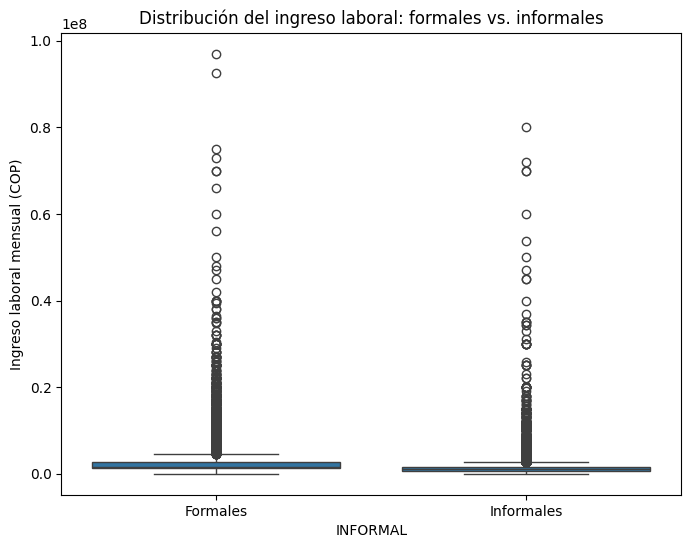

In [18]:

plt.figure(figsize=(8,6))
sns.boxplot(x='INFORMAL', y='INGLABO', data=master_trim_2025)
plt.xticks([0,1], ['Formales', 'Informales'])
plt.ylabel('Ingreso laboral mensual (COP)')
plt.title('Distribución del ingreso laboral: formales vs. informales')
plt.show()


In [19]:
df = master_trim_2025.copy()  # tu dataframe con ocupados y INFORMAL


df_dummies = pd.get_dummies(
    df,
    columns=['P3271', 'P6310', 'P3069', 'RAMA2D_R4'],
    drop_first=True
)



In [33]:
variables = [
    'INFORMAL',
    'P3271',        # sexo
    'P6040',        # edad
    'P3069',        # tamaño empresa
    'RAMA2D_R4',    # rama económica
    'P6920',        # pensión
    'UNIDAD_PEQUENA'
]
# Filtramos solo esas columnas y quitamos filas con NaN
df_model = df[variables].dropna()


In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Dummies para las categóricas
df_dummies = pd.get_dummies(
    df_model,
    columns=['P3271', 'P3069', 'RAMA2D_R4'],
    drop_first=True
)

# X e y
X = df_dummies.drop('INFORMAL', axis=1)
y = df_dummies['INFORMAL']

# Train / test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3, 
    random_state=42,
    stratify=y
)

# Modelo
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)

# Predicciones
y_pred = log_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nMatriz de confusión:\n", confusion_matrix(y_test, y_pred))
print("\nReporte de clasificación:\n", classification_report(y_test, y_pred))

# Coeficientes
coeficientes = pd.DataFrame({
    "Variable": X.columns,
    "Coeficiente": log_model.coef_[0]
}).sort_values("Coeficiente", ascending=False)

coeficientes


Accuracy: 0.8661829164978452

Matriz de confusión:
 [[10059  2601]
 [ 1032 13457]]

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.91      0.79      0.85     12660
           1       0.84      0.93      0.88     14489

    accuracy                           0.87     27149
   macro avg       0.87      0.86      0.86     27149
weighted avg       0.87      0.87      0.87     27149



,Variable,Coeficiente
1,P6920,2.017832
2,UNIDAD_PEQUENA,1.795727
5,P3069_3.0,1.491060
93,RAMA2D_R4_92.0,1.408148
73,RAMA2D_R4_69.0,1.142468
...,...,...
3,P3271_2,-1.089410
10,P3069_8.0,-1.238259
27,RAMA2D_R4_16.0,-1.444783
11,P3069_9.0,-1.553412


In [37]:
def map_rama_label(var):
    if var.startswith("RAMA2D_R4_"):
        codigo = int(float(var.replace("RAMA2D_R4_", "")))
        return f"{codigo} - {diccionario_ramas.get(codigo, 'Sin nombre')}"
    else:
        return var

coef_plot = coeficientes.copy()
coef_plot['Variable_legible'] = coef_plot['Variable'].apply(map_rama_label)

# ordenar por magnitud
coef_plot['abs_coef'] = coef_plot['Coeficiente'].abs()
coef_plot = coef_plot.sort_values('abs_coef', ascending=True)

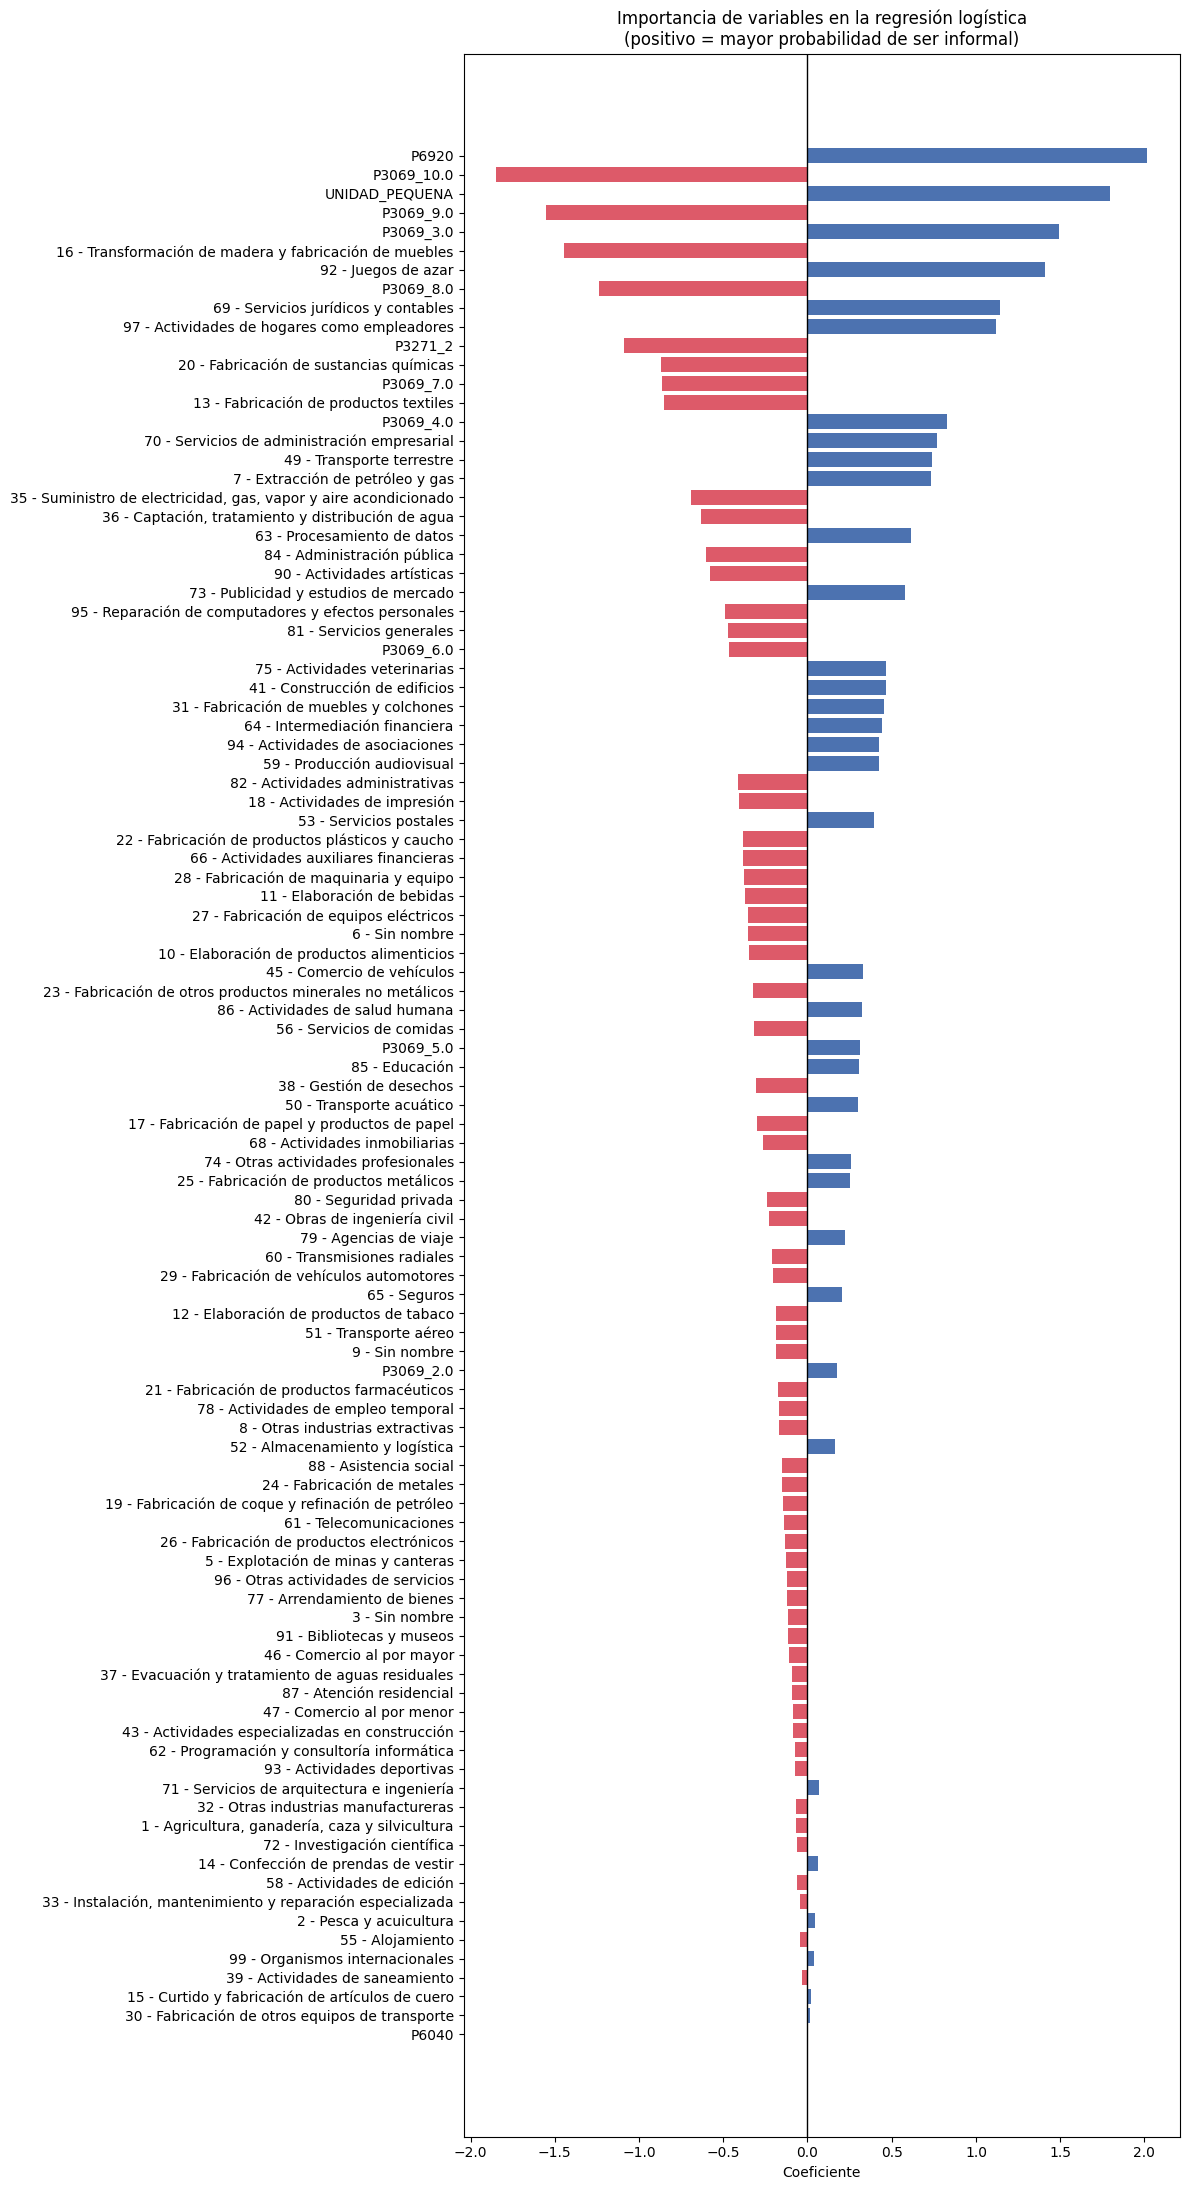

In [40]:
plt.figure(figsize=(12, 22))

plt.barh(
    coef_plot['Variable_legible'],
    coef_plot['Coeficiente'],
    color=['#4C72B0' if c > 0 else '#DD5A69' for c in coef_plot['Coeficiente']]
)

plt.axvline(0, color='black', linewidth=1)
plt.title("Importancia de variables en la regresión logística\n(positivo = mayor probabilidad de ser informal)")
plt.xlabel("Coeficiente")

plt.tight_layout()
plt.show()
